In [1]:
import matplotlib.pyplot as plt
import os
from os.path import dirname, abspath 
import sys
sys.path.append(abspath('..'))

from numpy import cos, sin

# SysOpt - Design Overview
## A system modelling and optimisation framework for codesign.

- Component based modelling tools for system capture
- Algorithmic model reduction (only 'flattening' so far)
- Uses existing autodiff tools for gradients.

In [44]:
import sysopt
backend = sysopt.get_default_backend()

  # System models using 'wires' and 'blocks'

### Building blocks using functions (dynamics)

In [3]:
from sysopt import Metadata
hsv_spec = Metadata(
    inputs=["Thrust", "Lift", "Drag", " Pitching Moment"],
    state=["Height", "Velocity", "AoA", "Body Angle", "Pitch Rate"],
    parameters=["mass", "gravity", "Inertial moment", "Initial Height", "Initial Velocity"]
)

In [4]:
def dxdt(t, x, u, p):
    h, V, alpha, theta, Q = x
    T, L, D, M = u
    m, g, I_yy, _, _ = p

    return [V * sin(theta - alpha),
            (T * cos(alpha) - D) / m - g * sin(theta - alpha),
            (-T * sin(alpha) - L) / (m * V) + Q + (g / V) * cos(theta - alpha),
            Q,
            M / I_yy]

In [5]:
def x0(p):
    _, _, _, h0, v0 = p
    return [h0, v0, 0, 0, 0]

In [6]:
# Create the block using a factory method.
from sysopt.blocks.builders import FullStateOutput
dynamics = FullStateOutput(metadata=hsv_spec, 
                           dxdt=dxdt, x0=x0)

### Build the blocks (using inheritance)

In [7]:
from sysopt import Block

class Propulsion(Block):
    def __init__(self):
        metadata = Metadata(
            inputs=["fuel-to-air ratio", "AoA"],
            outputs=["Thrust"],
            parameters=[f"beta_{i + 1}" for i in range(8)]
        )
        super().__init__(metadata)
    
    def compute_outputs(self, t, state, constraints, inputs, parameters):
        phi, alpha = inputs
        C_3 = parameters[0] * phi + parameters[1]
        C_2 = parameters[2] * phi + parameters[3]
        C_1 = parameters[4] * phi + parameters[5]
        C_0 = parameters[6] * phi + parameters[7]
        thrust = C_3 * alpha ** 3 + C_2 * alpha ** 2 + C_1 * alpha + C_0
        return thrust,

In [8]:
class AeroForces(Block):
    def __init__(self):
        metadata = Metadata(
            inputs=["Thrust", "Air Density", "Mach", "AoA", "deflection"],
            outputs=["Thrust", "Lift", "Drag", " Pitching Moment"],
        )
        super().__init__(metadata)
    
    def compute_outputs(self, t, state, constraints, u, p):
        thrust, rho, V, alpha, delta_e = u

        lift = 0         # insert calculations from parameters here
        drag = 0
        pitching_moment = 0
        return thrust, lift, drag, pitching_moment

In [9]:
class AtmosphereModel(Block):
    def __init__(self):
        metadata = Metadata(
            inputs=["altitude"],
            outputs=["temperature", "density", "pressure"],
        )
        super().__init__(metadata)
        
    def compute_outputs(self, t, x, z, u, p):
        h, = u
        # interpolate data or look up from table
        t, d, p = 0, 0, 0
        return t, d, p

### Step 3: Construct composite model

In [10]:
from sysopt import Composite

propulsion = Propulsion()
forces = AeroForces()   
atmosphere = AtmosphereModel()

aero_model = Composite()

aero_model.components = [dynamics, propulsion, forces, atmosphere]

aero_model.wires = [
    (aero_model.inputs[0],   propulsion.inputs[0]),  # expose fuel-to-air ratio as control
    (aero_model.inputs[1],   forces.inputs[4]),      # expose deflection as control
    (dynamics.outputs,       aero_model.outputs),    # forward the 5 dynamic states as outputs
    (propulsion.outputs[0],  forces.inputs[0]),      # Thrust -> forces
    (dynamics.outputs[0],    atmosphere.inputs[0]),  # Height -> atmopshere model
    (atmosphere.outputs[1],  forces.inputs[1]),      # Density  
    (forces.outputs,         dynamics.inputs),       # Connect forces
]

## Comments
- `Composite` -> Modularity and reusability.
- Symbolic backend is decoupled from model capture & analysis.
- Easily able to incorporate existing libraries for extra functionality.
- HSV Model is not yet complete - needs more components and loop closure (GNC).
- `sysopt` in early stages: next phase is parameteric optimisation, followed by uncertainty propogation. 

# Theory of Operation
- A Model is represented by a directed acyclic graph (DAG)
- Leaf Nodes are Constrained-Input-Output systems:
$$
\begin{aligned}
\dot{x}_i  &= f_i(t, x_i, z_i, u_i, p)\\
y_i &= g_i(t,x_i, z_i, u_i, p_i)\\
0 &= h_i (t,x_i, z_i, u_i, p_i)
\end{aligned}
$$
- Trunk Nodes are algebraic constraints between $y$'s and $u$'s

### Example: Dynamics

In [50]:
flattened_dynamics = backend.get_flattened_system(dynamics)
print(flattened_dynamics) 

[p_0, p_1, p_2, p_3, p_4]


### Example: Propulsion

In [52]:
flattened_prop = backend.get_flattened_system(propulsion)
print(flattened_prop.g)

((((((p_0*u_0)+p_1)*(u_1*sq(u_1)))+(((p_2*u_0)+p_3)*sq(u_1)))+(((p_4*u_0)+p_5)*u_1))+((p_6*u_0)+p_7))


### Compostion via constraints
For non-leaf nodes wires become algebraic constraints.

In [13]:
flattened_model = backend.get_flattened_system(aero_model)
print(flattened_model)

FlattenedSystem(X=SX([x_0, x_1, x_2, x_3, x_4]), Z=SX([u_0, u, u_1, u_0, u_1, u_2, u_3]), U=SX([u_0, u_4]), P=SX([p_0, p_1, p_2, p_3, p_4, p_0, p_1, p_2, p_3, p_4, p_5, p_6, p_7]), f=SX([(x_1*sin((x_3-x_2))), ((((u_0*cos(x_2))-u_2)/p_0)-(p_1*sin((x_3-x_2)))), ((x_4-(((u_0*sin(x_2))+u_1)/(p_0*x_1)))+((p_1/x_1)*cos((x_3-x_2)))), x_4, (u_3/p_2)]), g=SX([x_0, x_1, x_2, x_3, x_4]), h=SX([(u_0-((((((p_0*u_0)+p_1)*(u_1*sq(u_1)))+(((p_2*u_0)+p_3)*sq(u_1)))+(((p_4*u_0)+p_5)*u_1))+((p_6*u_0)+p_7))), (u-x_0), u_1, (u_0-u_0), u_1, u_2, u_3]), j=None, X0=SX(@1=0, [p_3, p_4, @1, @1, @1]))


In [14]:
# Constraints:
print("\n".join([f"0 = {flattened_model.h[i]}" for i in range(flattened_model.h.shape[0])]))

0 = (u_0-((((((p_0*u_0)+p_1)*(u_1*sq(u_1)))+(((p_2*u_0)+p_3)*sq(u_1)))+(((p_4*u_0)+p_5)*u_1))+((p_6*u_0)+p_7)))
0 = (u-x_0)
0 = u_1
0 = (u_0-u_0)
0 = u_1
0 = u_2
0 = u_3


# Simulation Capabilities:

Example system:


Cosine Oscillator -> Gain -> 1-pole Lowpass Filter -> Output


In [15]:
from sysopt.blocks.common import Gain, Oscillator, LowPassFilter
osc = Oscillator()
gain = Gain(channels=1)
lpf = LowPassFilter()

system = Composite()
system.components = [osc, gain, lpf]
system.wires = [
    (osc.outputs, gain.inputs),
    (gain.outputs, lpf.inputs),
    (lpf.outputs, system.outputs)
]


## Simulation Capabilities

Cosine Oscillator -> Gain -> 1-pole Lowpass Filter -> Output

Equations of motion: $\dot{x} + \gamma x = g \cos(\omega t + \phi), \qquad x(0) =0$

Solution is $ x(t) =Ae^{-\gamma t} + B\sin(\omega t + \phi) + C \cos(\omega t + \phi)$

Where $B = \frac{g\omega}{\gamma^2 + \omega^2}, C = \frac{g\omega}{\gamma^2 + \omega^2}, A = 1 - B \sin(\phi) - C\cos(\phi)$

In [53]:
flattened_system = backend.get_flattened_system(system)

y_parameterised = backend.integrator(flattened_system)

print(flattened_system.P) # omega, phi, g, gamma
parameters = [1, 0, 1, 1] 

[p_0, p_1, p, p]


## Numerical Solution

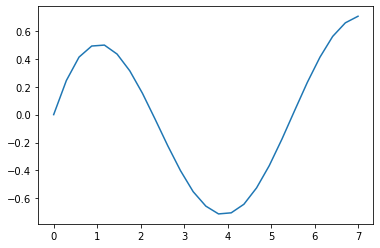

In [55]:
from numpy import linspace, pi
import matplotlib.pyplot as plt

T_max = 10
parameters = [1, 0, 1, 1]
y_path = y_parameterised(T_max, parameters)

t = linspace(0, 7, 25)
x_t = [float(y_path(t_i)) for t_i in t]
plt.plot(t, x_t)

## Take-aways from this simple example

- Parameterised models are simple to build an evaluate
- Heirarchical models are flattened into something a solvers can work with.
- System loop needs to be closed before simulating.
- Can define whatever outputs you want.

# Roadmap - Implementation
1. Parametric optimisation
2. Uncertainty propogation
3. HSV modelling - key GNC blocks
4. ROM algorithm integration
5. Hybrid system building blocks (DAC, ADC and discrete clocks)?